In [1]:
import sys
import os
import pandas as pd
import seaborn as sns


In [2]:
sys.path.append('..')

In [3]:
from icenode.train_icenode_2lr import ICENODE
from icenode.train_gram import GRAM
from icenode.train_retain import RETAIN

%load_ext autoreload
%autoreload 2

/home/asem/.conda/envs/icenode/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


In [4]:
HOME = os.environ.get('HOME')

# MIMIC-III Dataset Directory
mimic3_dir = f'{HOME}/GP/ehr-data/mimic3-transforms'

# ICE-NODE/M trained on MIMIC-III training partition (70%)
icenode_m3_params = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20.dynM3_icenode_2lr_M/trial_097/step0045_params.pickle'
icenode_m3_config = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20.dynM3_icenode_2lr_M/trial_097/config.json'

# RETAIN trained on MIMIC-III training partition (70%)
retain_m3_params = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20M3_retain_M/trial_171/step0099_params.pickle'
retain_m3_config = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20M3_retain_M/trial_171/config.json'

# GRU=GRAM/M trained on MIMIC-III training partition (70%)
gru_m3_params = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20M3_gram_M/trial_649/step0096_params.pickle'
gru_m3_config = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20M3_gram_M/trial_649/config.json'

# # GRAM=GRAM/G trained on MIMIC-III training partition (70%)
# gram_m3_dir = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.1.23M3_gram_G/frozen_trial_442'

## Patient Interface for each Model

In [5]:
icnode_patient_interface = ICENODE.create_patient_interface(mimic3_dir, 'M3')

In [6]:
retain_patient_interface = RETAIN.create_patient_interface(mimic3_dir, 'M3')
gram_patient_interface = GRAM.create_patient_interface(mimic3_dir, 'M3')

## Dataset Partitioning

In [7]:
import random

# seed 42 is used in all our experiments in this work.
rng = random.Random(42)
subjects_id = list(icnode_patient_interface.subjects.keys())
rng.shuffle(subjects_id)

# splits = train:val:test = 0.7:.15:.15
splits = int(.7 * len(subjects_id)), int(.85 * len(subjects_id))

train_ids = subjects_id[:splits[0]]
valid_ids = subjects_id[splits[0]:splits[1]]
test_ids = subjects_id[splits[1]:]

## Load Config/Params

In [8]:
from icenode.utils import load_config, load_params

icenode_config = load_config(icenode_m3_config)
icenode_params = load_params(icenode_m3_params)

retain_config = load_config(retain_m3_config)
retain_params = load_params(retain_m3_params)

gru_config = load_config(gru_m3_config)
gru_params = load_params(gru_m3_params)

# gram_config = load_config(f'{gram_m3_dir}/config.json')
# gram_params = load_params(f'{gram_m3_dir}/step0100_params.pickle')

## Load Models

In [9]:
icenode = ICENODE.create_model(icenode_config, icnode_patient_interface, train_ids, None)
icenode_state = icenode.init_with_params(icenode_config, icenode_params)

retain = RETAIN.create_model(retain_config, retain_patient_interface, train_ids, None)
retain_state = retain.init_with_params(retain_config, retain_params)


gru = GRAM.create_model(gru_config, gram_patient_interface, train_ids, None)
gru_state = gru.init_with_params(gru_config, gru_params)


## Per-code performance

In [10]:
from icenode.metrics import codes_auc_pairwise_tests

In [11]:
test_res = {
    'ICENODE': icenode.eval(icenode_state, test_ids)['diag_detectability'],
    'RETAIN': retain.eval(retain_state, test_ids)['diag_detectability'],
    'GRU': gru.eval(gru_state, test_ids)['diag_detectability']
}

In [12]:
tests_raw = codes_auc_pairwise_tests(test_res)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [01:01<00:00,  3.95it/s]


## Correlation between AUC and N_POS_CODES

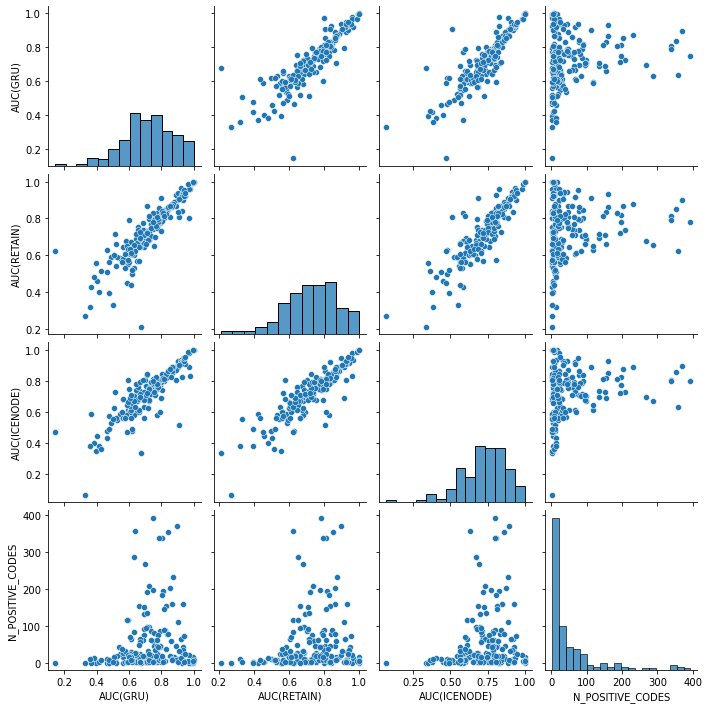

In [13]:
tests_raw_auc_corr = tests_raw[[f'AUC({clf})' for clf in ('GRU', 'RETAIN', 'ICENODE')] + ['N_POSITIVE_CODES']]
sns.pairplot(tests_raw_auc_corr)

In [14]:
flatccs_idx2code = {idx: code for code, idx in icnode_patient_interface.diag_flatccs_idx.items()}
idx2desc = lambda i: icnode_patient_interface.dag.diag_flatccs_desc[flatccs_idx2code[i]]
tests_raw['DESC'] = tests_raw['CODE_INDEX'].apply(idx2desc)
tests_raw

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
0,0,4.0,0.489303,0.525622,0.590547,0.869250,0.586623,0.597493,No DX
1,1,17.0,0.564101,0.683883,0.644628,0.115549,0.190191,0.597306,Tuberculosis
2,2,88.0,0.788767,0.785979,0.796071,0.832306,0.487360,0.493986,Immuniz/scrn
3,3,370.0,0.894996,0.893719,0.896929,0.805592,0.677353,0.584369,Acute MI
4,4,18.0,0.692679,0.628938,0.642337,0.259379,0.252416,0.843587,Coron athero
...,...,...,...,...,...,...,...,...,...
178,178,193.0,0.714232,0.720633,0.717521,0.658458,0.779997,0.797749,2ndary malig
179,179,146.0,0.815041,0.810830,0.811493,0.663386,0.670746,0.953321,Malig neopls
180,180,63.0,0.770714,0.777526,0.808014,0.643226,0.035524,0.120549,Neoplsm unsp
181,181,393.0,0.750262,0.797538,0.781738,0.000016,0.000026,0.061314,Maint chem/r


In [35]:
# remove codes that no classifier has scored above 0.6
at_least_AUC_07 = tests_raw.loc[:,[f'AUC({clf})' for clf in ('GRU', 'RETAIN', 'ICENODE')]].max(axis=1) > 0.7
tests = tests_raw[at_least_AUC_07]
tests

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
2,2,88.0,0.788767,0.785979,0.796071,0.832306,0.487360,0.493986,Immuniz/scrn
3,3,370.0,0.894996,0.893719,0.896929,0.805592,0.677353,0.584369,Acute MI
5,5,77.0,0.692534,0.710482,0.733488,0.482505,0.069347,0.202038,Chest pain
6,6,5.0,0.512749,0.728287,0.715538,0.001789,0.129492,0.864087,Pulm hart dx
7,7,111.0,0.904854,0.885923,0.911104,0.113010,0.344520,0.027530,Oth heart dx
...,...,...,...,...,...,...,...,...,...
178,178,193.0,0.714232,0.720633,0.717521,0.658458,0.779997,0.797749,2ndary malig
179,179,146.0,0.815041,0.810830,0.811493,0.663386,0.670746,0.953321,Malig neopls
180,180,63.0,0.770714,0.777526,0.808014,0.643226,0.035524,0.120549,Neoplsm unsp
181,181,393.0,0.750262,0.797538,0.781738,0.000016,0.000026,0.061314,Maint chem/r


In [36]:
tests.isnull().sum()

CODE_INDEX                     0
N_POSITIVE_CODES               0
AUC(GRU)                       0
AUC(ICENODE)                   0
AUC(RETAIN)                    0
P0(AUC_GRU==AUC_ICENODE)       0
P0(AUC_GRU==AUC_RETAIN)        1
P0(AUC_ICENODE==AUC_RETAIN)    0
DESC                           0
dtype: int64

In [37]:
# remove the code with null p-value
tests = tests[tests['P0(AUC_GRU==AUC_RETAIN)'].notnull()]

In [38]:
from collections import defaultdict
auc_sets = defaultdict(set)
clfs = ('GRU', 'ICENODE', 'RETAIN')
clfs_pairs = []
for i in range(len(clfs)):
    for j in range(i + 1, len(clfs)):
        clfs_pairs.append((clfs[i], clfs[j]))
clfs_pairs = tuple(clfs_pairs)

In [39]:
# Extract codes that are predicted with equivalent performance with all classifiers.
test_cols = tuple(f'P0(AUC_{clf1}==AUC_{clf2})' for (clf1, clf2) in clfs_pairs)

In [40]:
common_perf = tests[(tests[test_cols[0]] > 0.05) & (tests[test_cols[1]] > 0.05) & (tests[test_cols[2]] > 0.05)]
auc_sets[clfs] = set(common_perf.CODE_INDEX)

In [41]:
common_perf

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
2,2,88.0,0.788767,0.785979,0.796071,0.832306,0.487360,0.493986,Immuniz/scrn
3,3,370.0,0.894996,0.893719,0.896929,0.805592,0.677353,0.584369,Acute MI
5,5,77.0,0.692534,0.710482,0.733488,0.482505,0.069347,0.202038,Chest pain
8,8,337.0,0.806720,0.806097,0.810288,0.936501,0.600468,0.593591,Conduction
11,11,46.0,0.791842,0.812610,0.806447,0.400519,0.382460,0.757563,chf;nonhp
...,...,...,...,...,...,...,...,...,...
165,165,6.0,0.998338,0.999003,1.000000,0.593059,0.176433,0.231831,Testis cancr
168,168,78.0,0.841169,0.861646,0.860062,0.133344,0.110693,0.910440,Kidny/rnl ca
172,172,33.0,0.906483,0.901422,0.902105,0.536586,0.572521,0.927216,Hodgkin-s ds
178,178,193.0,0.714232,0.720633,0.717521,0.658458,0.779997,0.797749,2ndary malig


In [42]:
competing_tests = tests.drop(index=common_perf.index)

In [43]:
for index, row in competing_tests.iterrows():
    max_auc_clf = max(clfs, key=lambda clf: row[f'AUC({clf})'])
    relevant_tests = {(clf1, clf2): f'P0(AUC_{clf1}==AUC_{clf2})' for (clf1, clf2) in clfs_pairs if max_auc_clf in (clf1, clf2)}
    
    significant_max = True
    for (clf1, clf2), test_col in relevant_tests.items():
        # If max_auc_clf has maximum AUC, but without insigificant difference with another classifier
        # then consider both outperforming the third classifier.
        if row[test_col] > 0.05:
            significant_max = False
            auc_sets[(clf1, clf2)].add(int(row['CODE_INDEX']))
    
    if significant_max:
        auc_sets[max_auc_clf].add(int(row['CODE_INDEX']))

In [44]:
# Prepare for using Upset plot

best_sets = {}
for clf in clfs:
    best_sets[clf] = auc_sets[clf] | auc_sets[clfs]
    
    for clf1, clf2 in clfs_pairs:
        if clf in (clf1, clf2):
            best_sets[clf].update(auc_sets[(clf1, clf2)])
    

In [45]:
from upsetplot import from_contents, plot, UpSet
import matplotlib.pyplot as plt

In [46]:
upset_contents = from_contents(best_sets)

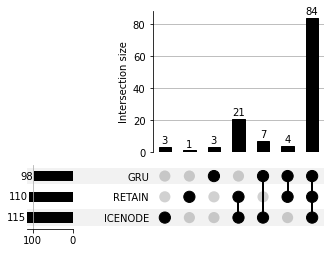

In [47]:
UpSet(upset_contents, subset_size='count', show_counts=True).plot()
plt.show()

In [48]:
icenode_best_tests = competing_tests[competing_tests['CODE_INDEX'].isin(best_sets['ICENODE'])]
retain_best_tests =  competing_tests[competing_tests['CODE_INDEX'].isin(best_sets['RETAIN'])]
gru_best_tests = competing_tests[competing_tests['CODE_INDEX'].isin(best_sets['GRU'])]

icenode_exc_best_tests = competing_tests[competing_tests['CODE_INDEX'].isin(auc_sets['ICENODE'])]
retain_exc_best_tests =  competing_tests[competing_tests['CODE_INDEX'].isin(auc_sets['RETAIN'])]
gru_exc_best_tests = competing_tests[competing_tests['CODE_INDEX'].isin(auc_sets['GRU'])]

In [49]:
icenode_exc_best_tests

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
47,47,20.0,0.655662,0.759808,0.645096,0.034159,0.821472,0.029197,Gastritis
112,112,85.0,0.632353,0.704966,0.622880,0.007767,0.679989,0.000373,Ot respir ca
169,169,17.0,0.614148,0.707424,0.611065,0.001978,0.915220,0.000749,Uriny org ca


In [50]:
retain_exc_best_tests

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
156,156,75.0,0.938601,0.942655,0.955774,0.463446,0.015558,0.040518,Uterus cancr


In [51]:
gru_exc_best_tests

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
21,21,98.0,0.725419,0.671498,0.681769,2.459141e-02,0.019013,0.612010,Ot circul dx
27,27,2.0,0.977656,0.828699,0.957299,1.199828e-03,0.000406,0.002475,Pneumonia
52,52,10.0,0.909910,0.513013,0.806907,2.910674e-09,0.000022,0.000009,Int obstruct


In [52]:
icenode_best_test_above07 = icenode_best_tests[icenode_best_tests['AUC(ICENODE)'] > 0.7]
icenode_best_test_above07

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
6,6,5.0,0.512749,0.728287,0.715538,0.001789,0.129492,0.864087,Pulm hart dx
10,10,353.0,0.839473,0.858020,0.850782,0.008616,0.068174,0.319353,Cardia arrst
14,14,27.0,0.774100,0.788244,0.752829,0.449434,0.104247,0.028963,Precere occl
19,19,8.0,0.647727,0.720405,0.566434,0.154305,0.248199,0.043366,Aneurysm
28,28,5.0,0.705080,0.767629,0.675199,0.175645,0.728348,0.044105,Influenza
31,31,63.0,0.689184,0.711735,0.738297,0.321528,0.008128,0.210487,Ot up rsp in
35,35,66.0,0.666394,0.732430,0.711414,0.015354,0.107320,0.390132,Stomch cancr
40,40,197.0,0.749537,0.775062,0.777256,0.036540,0.003244,0.844407,Ot uppr resp
45,45,28.0,0.641765,0.739479,0.686326,0.001682,0.183332,0.090425,Gasduo ulcer
46,46,18.0,0.708487,0.835744,0.864839,0.008204,0.039425,0.547001,Colon cancer


## Trajectories for Patients with CCS codes best predicted with ICENODE

### Analyse AUC for Each Admission in the Test Partition

In [33]:
icenode_visit_auc_df = icenode.admissions_auc_scores(icenode_state, test_ids)

In [34]:
icenode_visit_auc_df['N_VISITS'] = icenode_visit_auc_df['SUBJECT_ID'].apply(lambda i: (icenode_visit_auc_df['SUBJECT_ID'] == i).sum())
icenode_visit_auc_df

,SUBJECT_ID,HADM_ID,HADM_IDX,AUC,N_CODES,TIME,INTERVALS,LOS,R/T,NFE,N_VISITS
0,19842,169734,0,0.976900,7.0,412.5,412.5,3.5,0.0,26.0,5
1,19842,186772,1,0.939872,13.0,433.5,21.0,7.5,0.0,20.0,5
2,19842,180229,2,0.947650,8.0,448.5,15.0,3.5,0.0,20.0,5
3,19842,122439,3,0.944203,12.0,509.5,61.0,7.5,0.0,20.0,5
4,19842,163738,4,0.983078,11.0,552.5,43.0,5.5,0.0,20.0,5
...,...,...,...,...,...,...,...,...,...,...,...
1003,26421,192868,1,0.955274,5.0,278.5,186.0,3.5,0.0,26.0,2
1004,2558,105758,0,0.910348,9.0,59.5,59.5,4.5,0.0,20.0,2
1005,2558,194247,1,0.973860,7.0,70.5,11.0,4.5,0.0,14.0,2
1006,10832,196835,0,0.973860,7.0,647.5,647.5,8.5,0.0,26.0,2


In [43]:
visit_auc_subject = icenode_visit_auc_df.groupby('SUBJECT_ID').agg({'AUC': 'mean', 'N_VISITS': 'max', 'N_CODES': ['min', 'max', 'mean', 'median'], 'INTERVALS': ['mean', 'max', 'min'], 'R/T': ['min', 'max', 'mean'] })


In [49]:
best_visit_auc_subjects =  visit_auc_subject[(visit_auc_subject.AUC['mean'] > 0.7) & (visit_auc_subject.N_VISITS['max'] > 1) & (visit_auc_subject.N_VISITS['max'] <10) & (visit_auc_subject.INTERVALS['max'] < 90)]
best_visit_auc_subjects

AUC N_VISITS N_CODES                          INTERVALS  \
                mean      max     min   max       mean median       mean   
SUBJECT_ID                                                                 
2558        0.942104        2     7.0   9.0   8.000000    8.0  35.250000   
3365        0.949252        2     8.0   8.0   8.000000    8.0  57.250000   
9923        0.974690        2     7.0   8.0   7.500000    7.5  25.250000   
10634       0.876059        2     8.0  10.0   9.000000    9.0  22.750000   
10642       0.938640        3     6.0   8.0   7.000000    7.0  31.500000   
14749       0.977719        2     5.0   7.0   6.000000    6.0  39.250000   
17794       0.969620        2     5.0   5.0   5.000000    5.0  82.750000   
21892       0.944567        2     6.0  11.0   8.500000    8.5  49.750000   
22297       0.950857        2     8.0  10.0   9.000000    9.0  78.250000   
22578       0.915018        2     8.0  10.0   9.000000    9.0  54.250000   
26709       0.925885        3    12.0  13.0  12.333333   12.0  37.500000   
31170       0.960470        2     8.0   8.0   8.000000    8.0  28.750000   
40911       0.953608        5    12.0  15.0  14.000000   14.0  43.700000   
46287       0.925373        3     7.0  10.0   8.333333    8.0  47.166667   
47775       0.939398        2    13.0  16.0  14.500000   14.5  36.750000   
49037       0.918251        2     9.0  14.0  11.500000   11.5  17.750000   
56502       0.928084        2     6.0  11.0   8.500000    8.5  14.750000   
57330       0.893318        2    16.0  17.0  16.500000   16.5  38.750000   
59841       0.948664        3    10.0  11.0  10.333333   10.0  43.500000   
63177       0.949991        2    15.0  17.0  16.000000   16.0  46.750000   
66256       0.948508        2    13.0  14.0  13.500000   13.5  13.250000   
72847       0.927071        2     4.0   9.0   6.500000    6.5  49.250000   
77413       0.928496        2    11.0  13.0  12.000000   12.0  27.250000   
78419       0.911054        2     8.0  11.0   9.500000    9.5  45.750000   
98336       0.922957        2    15.0  20.0  17.500000   17.5  31.250000   

                        R/T            
             max   min  min  max mean  
SUBJECT_ID                             
2558        59.5  11.0  0.0  0.0  0.0  
3365        84.5  30.0  0.0  0.0  0.0  
9923        33.5  17.0  0.0  0.0  0.0  
10634       30.5  15.0  0.0  0.0  0.0  
10642       43.0  23.0  0.0  0.0  0.0  
14749       50.5  28.0  0.0  0.0  0.0  
17794       85.0  80.5  0.0  0.0  0.0  
21892       62.5  37.0  0.0  0.0  0.0  
22297       83.0  73.5  0.0  0.0  0.0  
22578       57.5  51.0  0.0  0.0  0.0  
26709       49.5  27.0  0.0  0.0  0.0  
31170       43.0  14.5  0.0  0.0  0.0  
40911       69.0   7.0  0.0  0.0  0.0  
46287       76.5   7.0  0.0  0.0  0.0  
47775       41.0  32.5  0.0  0.0  0.0  
49037       18.5  17.0  0.0  0.0  0.0  
56502       21.0   8.5  0.0  0.0  0.0  
57330       42.5  35.0  0.0  0.0  0.0  
59841       73.0  24.5  0.0  0.0  0.0  
63177       57.5  36.0  0.0  0.0  0.0  
66256       22.5   4.0  0.0  0.0  0.0  
72847       64.0  34.5  0.0  0.0  0.0  
77413       36.0  18.5  0.0  0.0  0.0  
78419       53.0  38.5  0.0  0.0  0.0  
98336       44.0  18.5  0.0  0.0  0.0

In [50]:
ccs_history = {i: icnode_patient_interface.diag_flatccs_history(i)[1] for i in best_visit_auc_subjects.index}

In [51]:
ccs_history_icenode_best = {i: history for i, history in ccs_history.items() if len(set(history) & set(icenode_best_test_above07['CODE_INDEX']))> 0}

In [52]:
ccs_history_icenode_best

{3365: [240, 66, 155, 238, 11, 37, 9, 190, 184, 4, 100, 44],
 9923: [187,
  238,
  11,
  64,
  12,
  189,
  4,
  65,
  241,
  184,
  63,
  58,
  190,
  185,
  196,
  239],
 17794: [18, 40, 240, 19, 9, 190, 4, 15],
 22578: [115,
  240,
  11,
  64,
  9,
  4,
  125,
  32,
  6,
  155,
  55,
  111,
  190,
  53,
  5,
  3,
  41,
  22,
  175],
 31170: [48, 155, 47, 209, 60, 198, 195, 212, 22, 44, 200, 184],
 40911: [18,
  187,
  39,
  27,
  198,
  113,
  241,
  71,
  117,
  6,
  191,
  190,
  226,
  8,
  185,
  192,
  21,
  238,
  11,
  64,
  37,
  3,
  237,
  9,
  33,
  183,
  189,
  65,
  4,
  66,
  60,
  155,
  164,
  196],
 49037: [240,
  70,
  119,
  37,
  64,
  22,
  197,
  10,
  198,
  33,
  60,
  66,
  58,
  164,
  185,
  196,
  192,
  44,
  200,
  175],
 56502: [39, 37, 84, 33, 209, 203, 40, 188, 131, 220, 196, 192],
 57330: [240,
  27,
  241,
  195,
  191,
  47,
  190,
  200,
  21,
  37,
  64,
  11,
  3,
  237,
  68,
  33,
  183,
  209,
  4,
  65,
  32,
  145,
  111,
  178,
  53,
  1

In [53]:
len(ccs_history_icenode_best)

14

In [ ]:
trajectory = icenode.sample_trajectory(icenode_state, ccs_history_icenode_best.keys(), 1)

  0%|                                                                                                                                                                               | 0/41 [00:00<?, ?it/s]/home/asem/GP/ICENODE/analysis/../icenode/train_icenode_tl.py:408: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pos[[top10_idx]] = 1
  2%|████                                                                                                                                                                | 1/41 [12:31<8:21:00, 751.52s/it]

In [97]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [99]:
ccs_index = list(icenode_best_test_above07['CODE_INDEX'])
idx2desc = lambda idx: icnode_patient_interface.dag.diag_flatccs_desc[flatccs_idx2code[idx]]
ccs_description = list(map(idx2desc, ccs_index))


In [101]:
data = {}
for i, traj in trajectory.items():
    diag_times = icnode_patient_interface.diag_times(i)
    
    t = traj['t']
    d = traj['d']
    
    prob = []
    time = []
    code = []
    
    for ccs_desc, ccs_idx in zip(ccs_description, ccs_index):
        time.append(t)
        code.extend([ccs_desc]*len(t))
        prob.append(d[:, ccs_idx])

    prob = np.hstack(prob)
    time = np.hstack(time)
    
    
    df = pd.DataFrame({'t': time, r'$\hat{v}$': prob, 'code': code})
    data[i] = (df, diag_times)
    

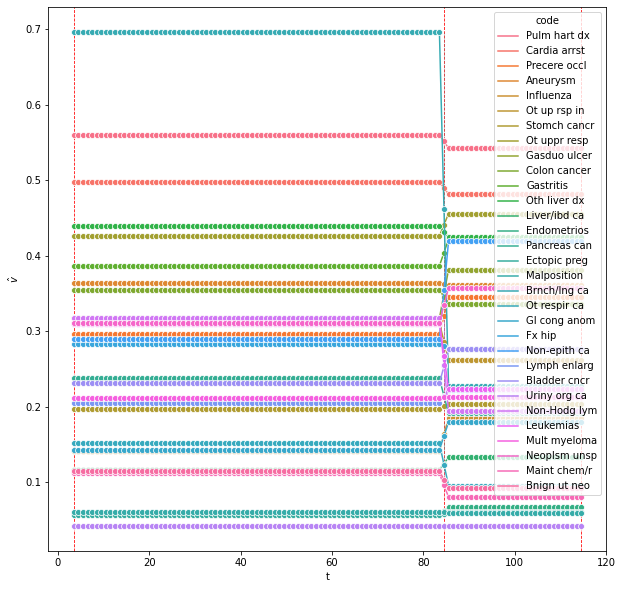

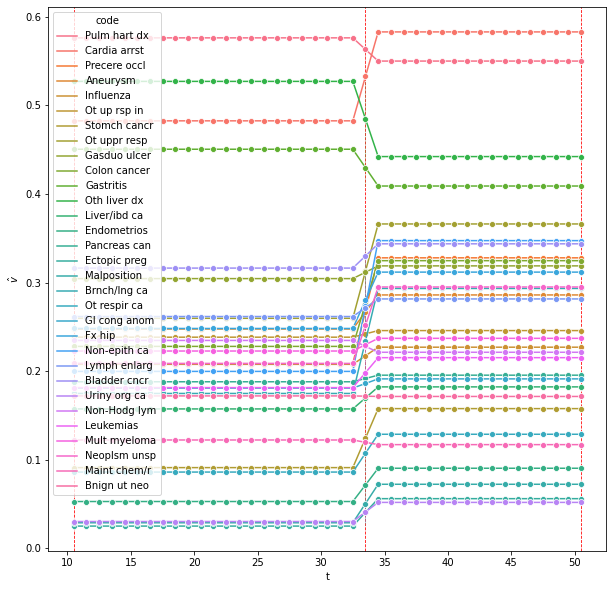

In [116]:
plt.rcParams['figure.figsize']=(10,10)
import math
for i, (df, diag_times) in data.items():

    plt.figure(i)
    
    g = sns.lineplot(data=df, x="t", y=r'$\hat{v}$', hue='code', marker='o')
    for diag_time in diag_times:
        g.axvline(x=diag_time, ymin=0, ymax=1, c="red", ls='--', linewidth=0.8, zorder=0, clip_on=False)

It seems that we cannot catch the smoothness of the trajectory as it evolves very quickly to the saturation value.